# **Predict Daily Minimum Temperatures**

## **Importing Libraries**

In [24]:
import time
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import LSTM, Dense

## **Loading Dataset**

In [13]:
# Replace with your local path or Kaggle path
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv'

df = pd.read_csv(url, parse_dates=['Date'])

In [14]:
df.head()

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    3650 non-null   datetime64[ns]
 1   Temp    3650 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 57.2 KB


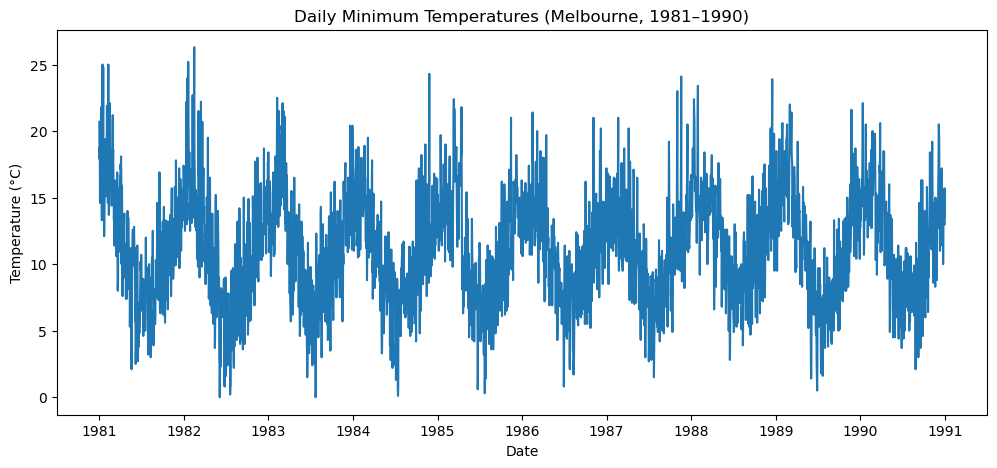

In [11]:
plt.figure(figsize=(12,5))
plt.plot(df['Date'], df['Temp'])
plt.title('Daily Minimum Temperatures (Melbourne, 1981–1990)')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.show()

## **Data Preprocessing**

In [17]:
# Extract temperature values
temps = df['Temp'].values.reshape(-1, 1)

# Normalize between 0 and 1
scaler = MinMaxScaler(feature_range=(0,1))
temps_scaled = scaler.fit_transform(temps)

# Helper function: convert series to supervised learning
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

# Use past 7 days to predict the next day's temperature
window_size = 7
X, y = create_sequences(temps_scaled, window_size)

print("Input shape:", X.shape, "Output shape:", y.shape)

Input shape: (3643, 7, 1) Output shape: (3643, 1)


## **Train/Test Split**

In [18]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print("Train samples:", len(X_train), "Test samples:", len(X_test))

Train samples: 2914 Test samples: 729


## **Feedforward Neural Network (Baseline)**

In [20]:
# Flatten each sequence (7 days) into one vector
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Define simple Feedforward NN
ff_model = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_flat.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

ff_model.compile(optimizer='adam', loss='mse')

# Train and time it
t0 = time.time()
history_ff = ff_model.fit(X_train_flat, y_train, epochs=50, batch_size=32,
                          validation_split=0.1, verbose=0)
t1 = time.time()
print(f"Feedforward NN training time: {t1 - t0:.2f}s")

C:\Users\bbuser\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Feedforward NN training time: 63.94s


## **Recurrent Neural Network (LSTM)**

In [23]:
rnn_model = models.Sequential([
    LSTM(64, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(32, activation='relu'),
    Dense(1)
])

rnn_model.compile(optimizer='adam', loss='mse')

# Train and time it
t0 = time.time()
history_rnn = rnn_model.fit(X_train, y_train, epochs=50, batch_size=32,
                            validation_split=0.1, verbose=0)
t1 = time.time()
print(f"RNN (LSTM) training time: {t1 - t0:.2f}s")

C:\Users\bbuser\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


RNN (LSTM) training time: 78.40s


## **Compare Performance**

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step 
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step  
Feedforward NN RMSE: 2.245
RNN (LSTM) RMSE: 2.263


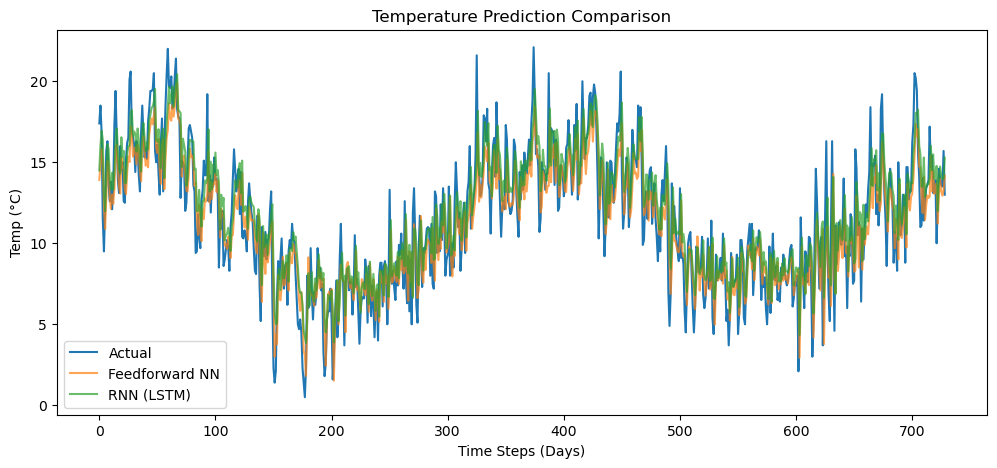

In [25]:
# Predictions
y_pred_ff = ff_model.predict(X_test_flat)
y_pred_rnn = rnn_model.predict(X_test)

# Inverse transform back to Celsius
y_test_inv = scaler.inverse_transform(y_test)
y_pred_ff_inv = scaler.inverse_transform(y_pred_ff)
y_pred_rnn_inv = scaler.inverse_transform(y_pred_rnn)

# RMSE
rmse_ff = np.sqrt(mean_squared_error(y_test_inv, y_pred_ff_inv))
rmse_rnn = np.sqrt(mean_squared_error(y_test_inv, y_pred_rnn_inv))

print(f"Feedforward NN RMSE: {rmse_ff:.3f}")
print(f"RNN (LSTM) RMSE: {rmse_rnn:.3f}")

# Plot actual vs predicted
plt.figure(figsize=(12,5))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_ff_inv, label='Feedforward NN', alpha=0.7)
plt.plot(y_pred_rnn_inv, label='RNN (LSTM)', alpha=0.7)
plt.title('Temperature Prediction Comparison')
plt.xlabel('Time Steps (Days)')
plt.ylabel('Temp (°C)')
plt.legend()
plt.show()